[`stackstac`](https://github.com/gjoseph92/stackstac) is a python package for
making it dead simple to process data from a STAC using
[`xarray`](https://xarray.dev/).
When you use `stackstac`, you do not need to write any code to handle merging
operations for many raster files.
The data come out the other side in a neatly packaged `xarray` object with
`x`, `y`, `time`, and `band` dimensions!
This is very convenient when you are interested in an arbitrary area that may
require combining data from many STAC items.
The [`stackstac` documentation](https://stackstac.readthedocs.io/en/latest/) is
very good, but I have put this demo together to highlight a few things that
I really like about the STAC + `stackstac` + `xarray` workflow.

### Define search parameters
I am interested in getting a mosaic of daily observations from Sentinel 2 for
September 2022.


In [1]:
import pyproj
import pystac_client
import stackstac
import xarray as xr
from shapely.geometry import box
from shapely.ops import transform

# STAC connection information for Sentinel 2 COGs
STAC_URL = "https://earth-search.aws.element84.com/v0"
STAC_COLLECTION = "sentinel-s2-l2a-cogs"

# spatial projection information
CRS_STRING = "epsg:5070"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

# area of interest along the North Shore of Lake Superior
AOI = box(373926, 2744693, 406338, 2765304)

# a few more parameters
RESOLUTION = 100  # meters
BANDS = ["B04", "B03", "B02"]
START_DATE = "2022-09-01"
END_DATE = "2022-09-30"

### Query the STAC for matching items
To query the STAC, we need to provide a bounding box in `epsg:4326` coordinates:


In [2]:
# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)

bbox_4326 = transform(transformer_4326.transform, AOI).bounds

This will return all of the STAC items that intersect the provided bounding box
and time window:


In [3]:
catalog = pystac_client.Client.open(STAC_URL)

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
).get_all_items()

The query yields many STAC items, each of which describes multiple COGs (one per
band).
Using other tools, we would need to write a bunch of code to make sure we
combine the data correctly but with `stackstac` we can forget about that and
just get on with our analysis!


In [4]:
len(stac_items)

20

### Stack it
Lazily load the raster data into an `xarray.DataArray` using `stackstack.stack`.
This function uses the STAC item metadata to construct a multidimensional array
with human-readable coordinates that can be manipulated with the magnificently
powerful suite of `xarray` functions and methods!

In [5]:
sentinel_stack = stackstac.stack(
    items=stac_items,
    assets=BANDS,
    epsg=EPSG,
    resolution=RESOLUTION,
    bounds=AOI.bounds,
    xy_coords="center",
)
sentinel_stack

<xarray.DataArray 'stackstac-22d3c071b7dc36f0e291499abc196816' (time: 20,
                                                                band: 3,
                                                                y: 208, x: 325)>
dask.array<fetch_raster_window, shape=(20, 3, 208, 325), dtype=float64, chunksize=(1, 1, 208, 325), chunktype=numpy.ndarray>
Coordinates: (12/29)
  * time                          (time) datetime64[ns] 2022-09-03T17:10:24 ....
    id                            (time) <U24 'S2B_15UXP_20220903_0_L2A' ... ...
  * band                          (band) <U3 'B04' 'B03' 'B02'
  * x                             (x) float64 3.74e+05 3.74e+05 ... 4.064e+05
  * y                             (y) float64 2.765e+06 2.765e+06 ... 2.745e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220903T165849_N04...
    ...                            ...
    title                         (band) <U14 'Band 4 (red)' ... 'Band 2 (blue)'
    proj:shape                    object {10980}
    common_name                   (band) <U5 'red' 'green' 'blue'
    center_wavelength             (band) float64 0.6645 0.56 0.4966
    full_width_half_max           (band) float64 0.038 0.045 0.098
    epsg                          int64 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(373900, 2744600, 406400, 27654...
    crs:         epsg:5070
    transform:   | 100.00, 0.00, 373900.00|\n| 0.00,-100.00, 2765400.00|\n| 0...
    resolution:  100

The `resolution` argument makes it possible to resample the input data
on-the-fly.
In this case, I am downsampling from the original 20 meter resolution to 100
meters.

### Wrangle the time dimension

One thing to watch out for with `stackstac.stack` is that you will wind up with
a distinct time coordinate for each STAC item that you pass in.
To achieve the intuitive representation of the data, you need to flatten the
`DataArray` with respect to day.

**Note:** if you are only reading a single STAC item, `stackstac.mosaic` will
inadvertently reduce your data along the `band` dimension (which is definitely
not what you want!), hence the conditional statement checking for more than
one time coordinate value.


In [6]:
def flatten(x, dim="time"):
    assert isinstance(x, xr.DataArray)
    if len(x[dim].values) > len(set(x[dim].values)):
        x = x.groupby(dim).map(stackstac.mosaic)

    return x


# round time coordinates so all observations from the same day so they have
# equivalent timestamps
sentinel_stack = sentinel_stack.assign_coords(
    time=sentinel_stack.time.astype("datetime64[D]")
)

# mosaic along time dimension
flat_stack = flatten(sentinel_stack, dim="time")
flat_stack

<xarray.DataArray 'stackstac-22d3c071b7dc36f0e291499abc196816' (time: 10,
                                                                band: 3,
                                                                y: 208, x: 325)>
dask.array<concatenate, shape=(10, 3, 208, 325), dtype=float64, chunksize=(1, 1, 208, 325), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * band                          (band) <U3 'B04' 'B03' 'B02'
  * x                             (x) float64 3.74e+05 3.74e+05 ... 4.064e+05
  * y                             (y) float64 2.765e+06 2.765e+06 ... 2.745e+06
    sentinel:valid_cloud_cover    bool True
    sentinel:utm_zone             int64 15
    proj:epsg                     int64 32615
    ...                            ...
    proj:shape                    object {10980}
    common_name                   (band) <U5 'red' 'green' 'blue'
    center_wavelength             (band) float64 0.6645 0.56 0.4966
    full_width_half_max           (band) float64 0.038 0.045 0.098
    epsg                          int64 5070
  * time                          (time) datetime64[ns] 2022-09-03 ... 2022-0...
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(373900, 2744600, 406400, 27654...
    crs:         epsg:5070
    transform:   | 100.00, 0.00, 373900.00|\n| 0.00,-100.00, 2765400.00|\n| 0...
    resolution:  100

Up until now, we have not processed any actual raster data!
All of the operations have been carried out using the STAC item information and
associated raster metadata from the source files.
By working in this way, you can iterate very rapidly making sure that the
dimensions of the output matches your expectation **before** you process any
actual data.

### Load the data into memory and take a look
You can keep going with an analysis 100% lazily until the very end, but this 
time I am just making a plot so we have reached the end of the lazy road.
Calling the `compute` method will execute the lazily-evaluated operations that
we queued up for `flat_stack`.


In [7]:
flat_stack = flat_stack.compute()

We can view the images easily with the `plot` method, giving us a glimpse into
autumn on the North Shore of Lake Superior!


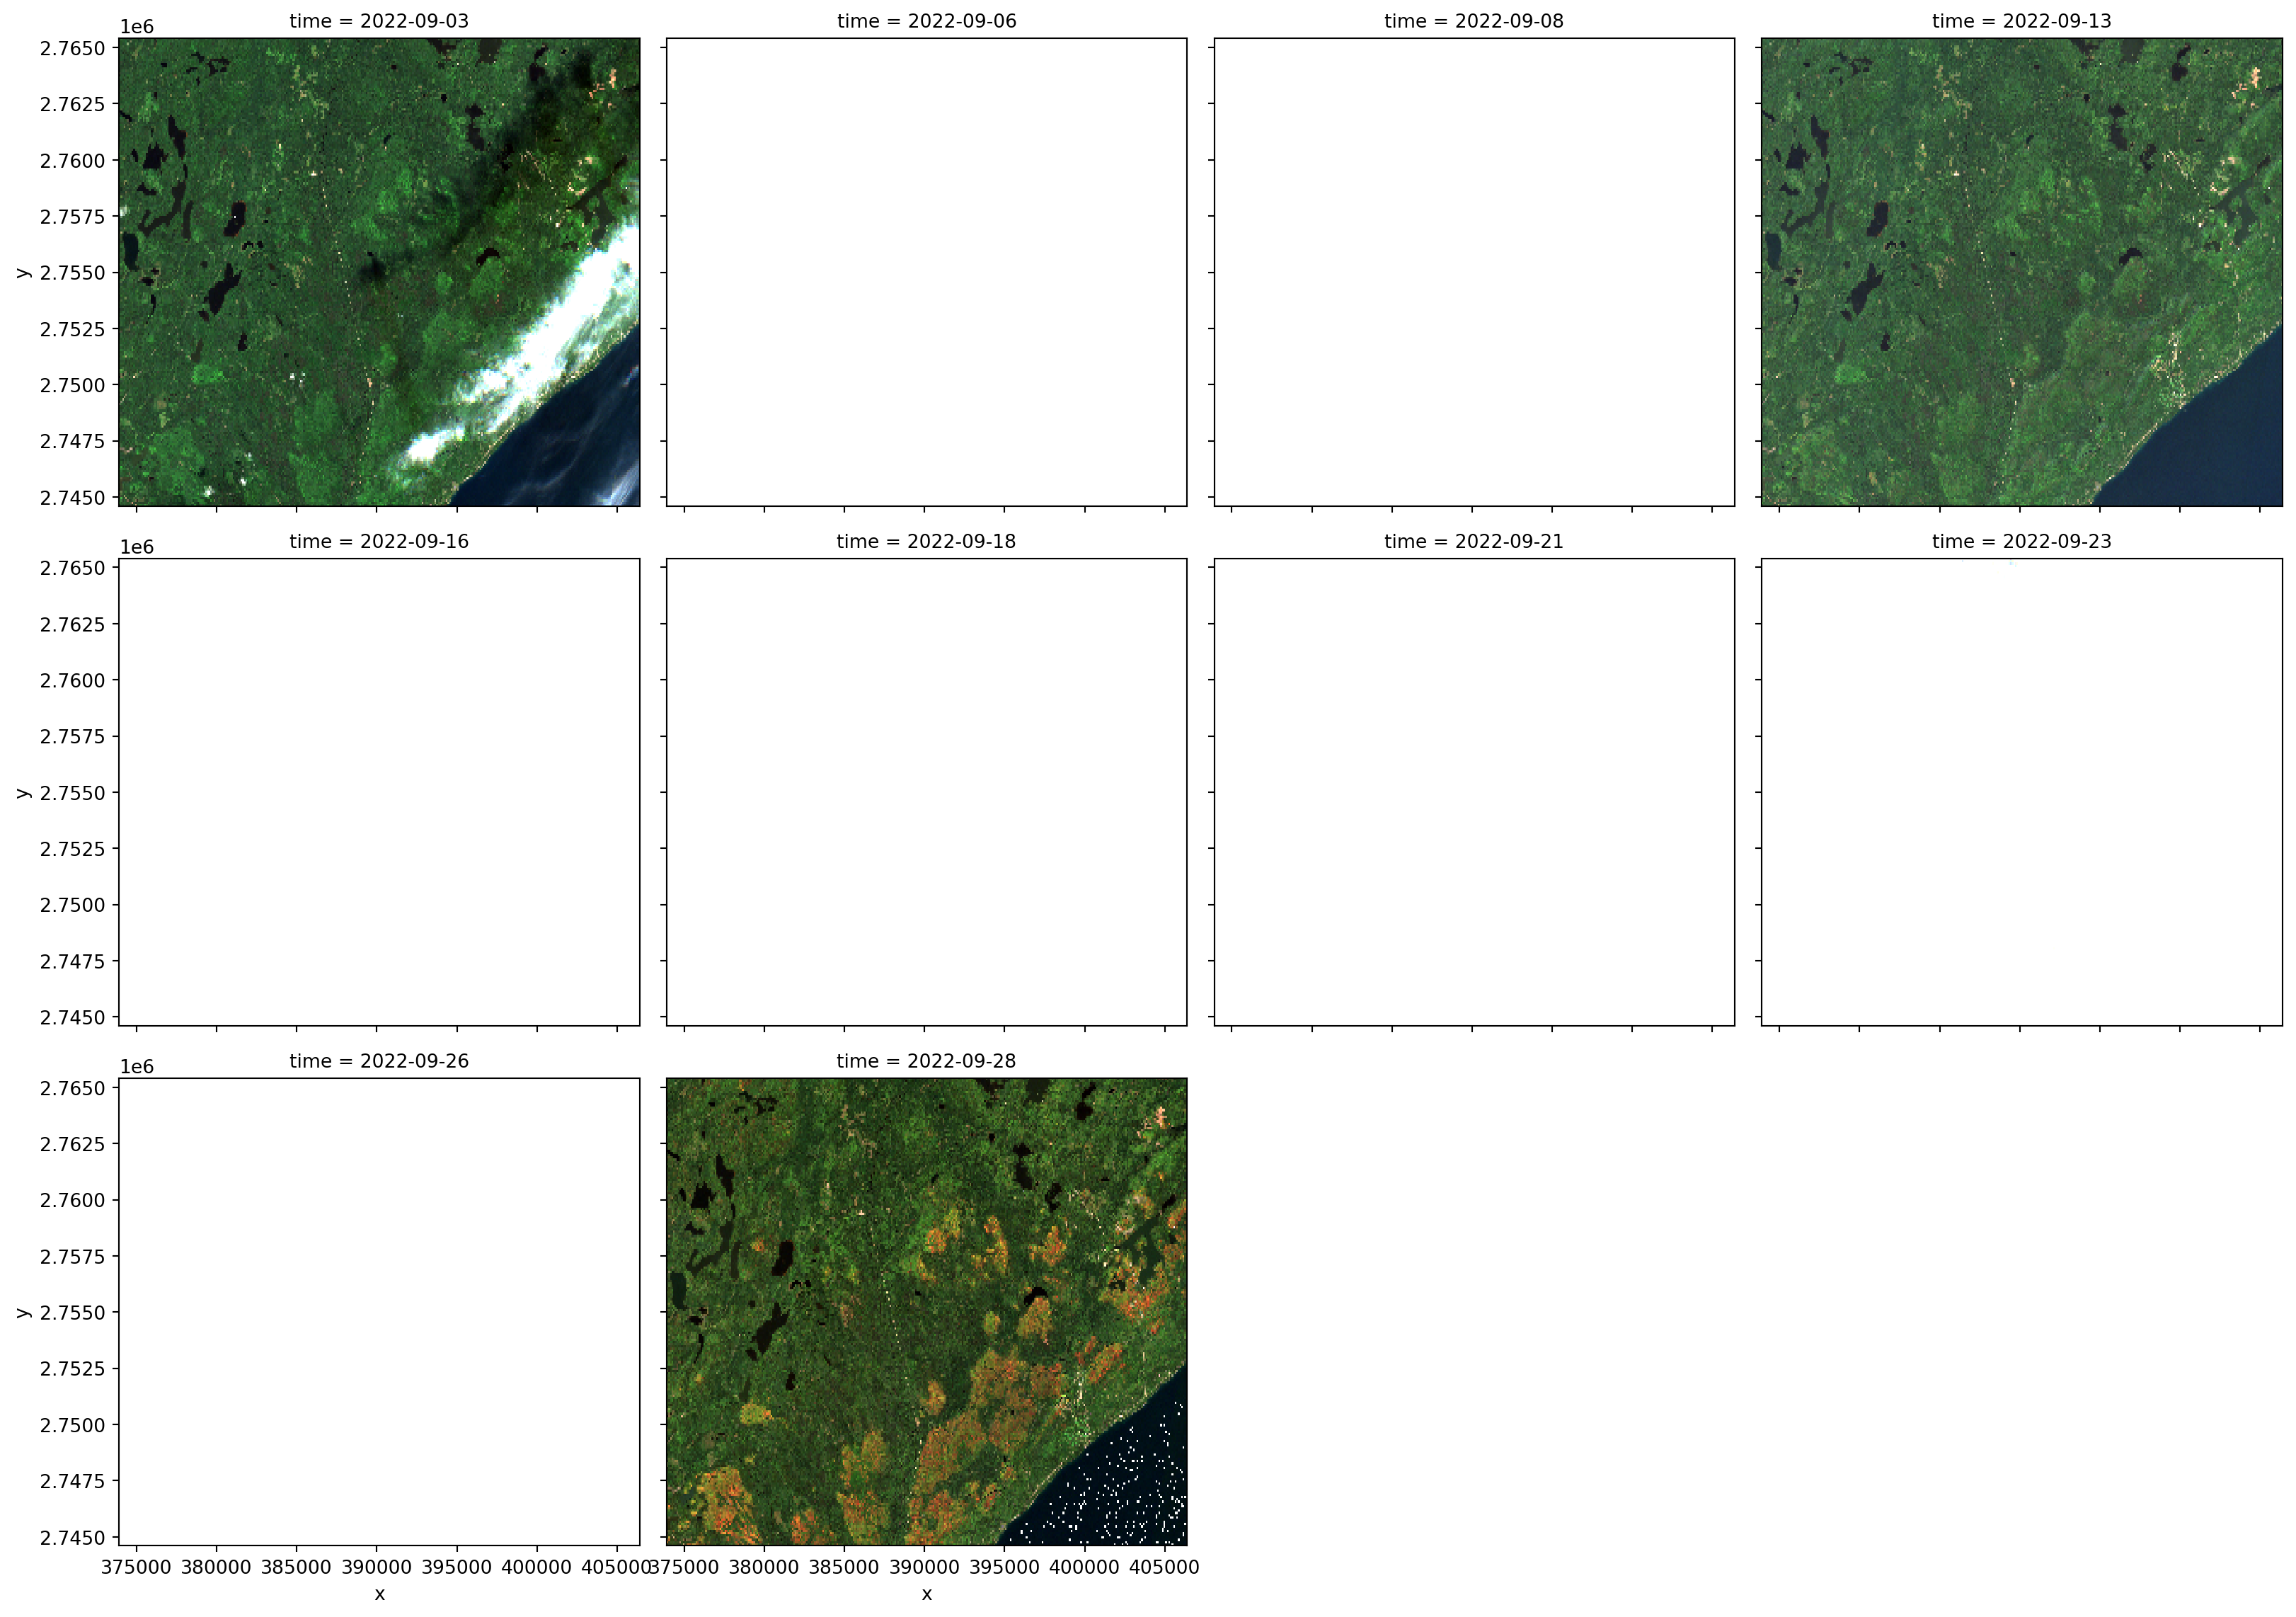

In [8]:
# | column: screen
flat_stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    col="time",
    col_wrap=4,
    rgb="band",
    robust=True,
    size=4,
    vmin=0,
    vmax=1000,
    add_labels=False,
)

I remember it being cloudy last fall but damn we had a couple of nice days!
Apparently September 28 was a really good one.

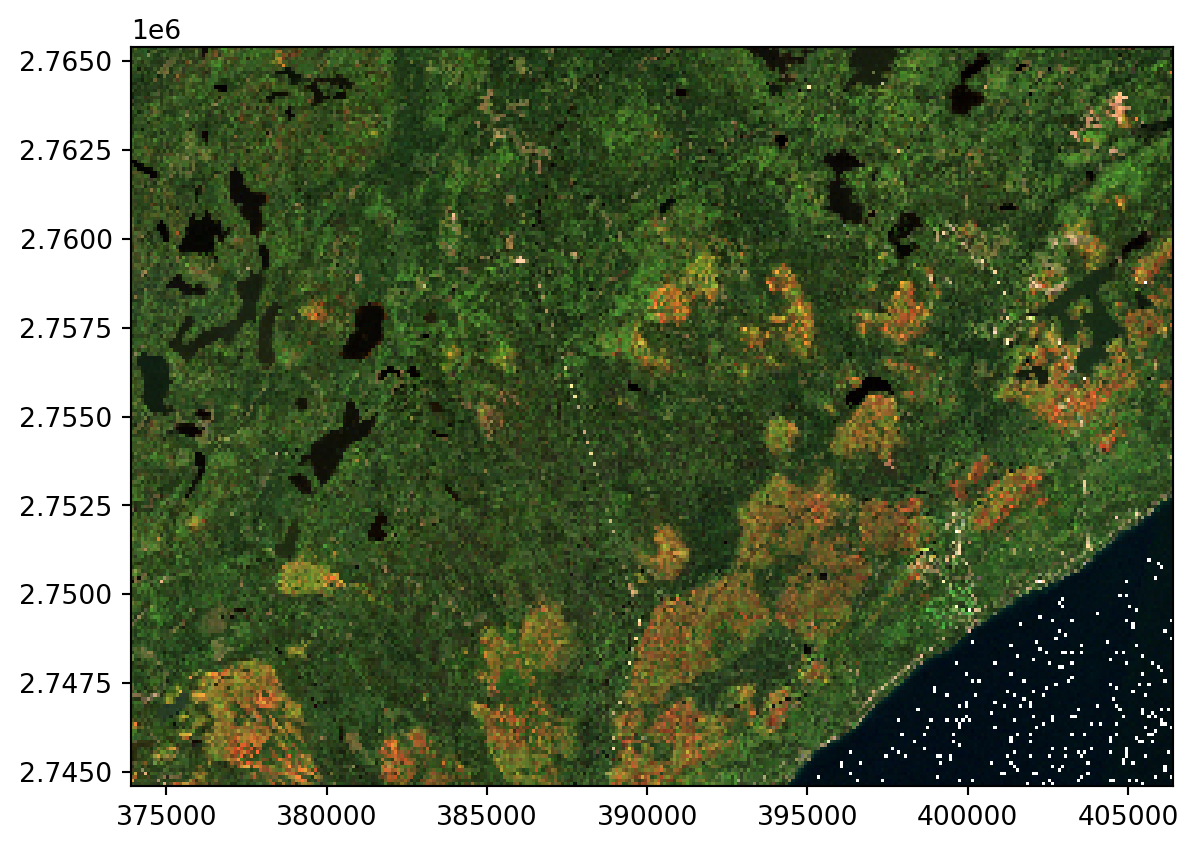

In [9]:
flat_stack.sel(band=["B04", "B03", "B02"], time="2022-09-28").plot.imshow(
    rgb="band",
    robust=True,
    size=5,
    vmin=0,
    vmax=1000,
    add_labels=False,
)

### Whats next?
This is really just scratching the surface of what you can do with `xarray`,
I will try to cover some more advanced topics in later posts.
